In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [64]:
#  Inputs config

cWtil_vals = [0, -0.4, -0.2, 0.2, 0.4]
#cWtil_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
#cWtil_vals = [0, -0.4, 0.4]

cWtil_eval_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

input_fnames = {}
input_fnames [0   ] = "../Data/SM_EWK_1M_rivet_output.pickle"

#  "../Data/SM_EWK_rivet_output.pickle"
#  "../Data/SM_EWK_500k_rivet_output.pickle"
#  "../Data/SM_EWK_1M_rivet_output.pickle"

input_fnames [-0.4] = "../Data/cWtil_m0p4_full_200k_rivet_output.pickle"
input_fnames [-0.3] = "../Data/cWtil_m0p3_full_200k_rivet_output.pickle"
input_fnames [-0.2] = "../Data/cWtil_m0p2_full_200k_rivet_output.pickle"
input_fnames [-0.1] = "../Data/cWtil_m0p1_full_200k_rivet_output.pickle"
input_fnames [ 0.1] = "../Data/cWtil_0p1_full_200k_rivet_output.pickle"
input_fnames [ 0.2] = "../Data/cWtil_0p2_full_200k_rivet_output.pickle"
input_fnames [ 0.3] = "../Data/cWtil_0p3_full_200k_rivet_output.pickle"
input_fnames [ 0.4] = "../Data/cWtil_0p4_full_200k_rivet_output.pickle"


In [65]:
#  Model config

output_size_per_stage     = 15
max_epochs                = 50
batch_size                = 200
epoch_increase_per_level  = 20
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.5

white_linear_fraction_data  = 0.3
white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 3, 2, 2

load_whitening_funcs = None    # ".whitening_funcs.pickle"
save_whitening_funcs = ".whitening_funcs.pickle"   # ".whitening_funcs.pickle"

load_model_dir = None
save_model_dir = ".EWK_density_model"     # ".EWK_density_model"

learning_rate = 0.001     # 0.01 for SGD or 0.001 otherwise
optimiser     = "adam"     # SGD, Adam or AdaDelta

In [66]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [67]:
#  Load and format the data
#

data_tables = {}
for cWtil in cWtil_eval_vals :
    input_fname = input_fnames [cWtil]
    print(f"Creating data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables [cWtil] = data
    

Creating data table for cWtil=0
 -- events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 642591 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 642591 events s

 -- 128530 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 128530 events survived
 -- removing observable N_jets
 -- removing observable pT_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | m_jj     | <class 'float'> |
    | 1      | m_ll     | <class 'float'> |
    | 2      | Dphi_j_j | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.1468         |
    +

 -- 132342 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132326 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132326 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130576 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128713 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128713 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128713 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128713 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128683 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 128598 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128598 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 128598 events survived
 -- filtering observable N_jets between 2 and 5
 -- 128598 e

In [68]:

whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data, white_linear_fraction_gauss] for key in data.keys]

observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cWtil in cWtil_vals :
    data = data_tables [cWtil]
    #  Seperate data from weights
    observable_data [cWtil], weight_data [cWtil] = data.get_observables_and_weights()
    #  Whiten data
    print(f"Whitening dataset for cWtil={cWtil}")
    white_data_to_fit[cWtil], whitening_funcs = whiten_axes (observable_data[cWtil], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights(), 
                                                             func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)

if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Whitening dataset for cWtil=0
Whitening dataset for cWtil=-0.4
Whitening dataset for cWtil=-0.2
Whitening dataset for cWtil=0.2
Whitening dataset for cWtil=0.4
Saving whitening functions to file .whitening_funcs.pickle


In [20]:

weights_to_fit = {k:(1+np.fabs(k)/np.max(np.fabs(cWtil_vals)))*i/np.sum(i) for k,i in weight_data.items()}


Filter efficiency is 100.000%


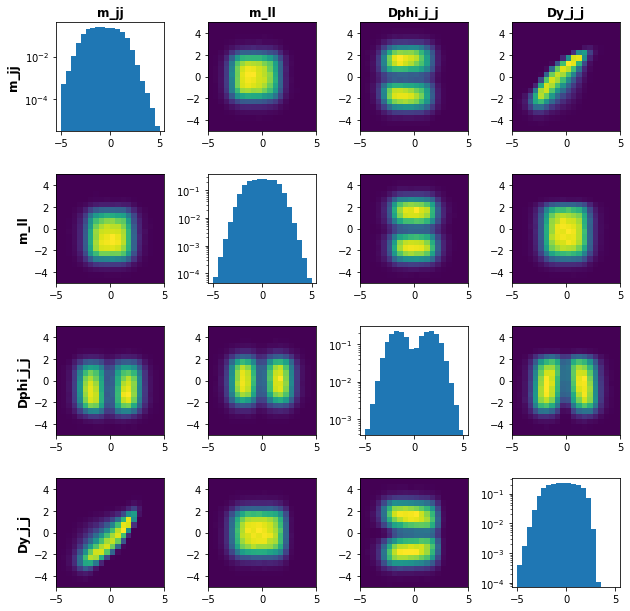

In [21]:

plot_data(white_data_to_fit[0]    , weights_to_fit        [0]  , keys=data.keys, bins=20, lims=False)


In [9]:
#  Load model if requested, otherwise build and fit
#

if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #  Create density model
    density_model = DensityModel(name            = "QCD_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data.get_num_observables(), 
                                 types           = data.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose         = True,
                                 learning_rate   = learning_rate,
                                 optimiser       = optimiser)
    fit_times = {}
    for obs_idx in range(white_data_to_fit[0].shape[1]) :
        fit_start_time = time.time()
        num_epochs = max_epochs + obs_idx*epoch_increase_per_level
        density_model.fit(white_data_to_fit, 
                          weights_to_fit,
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 15
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating continuous density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 15
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 50
INFO       DensityModel.fit              -  Training setting: batch_size = 200
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 418000 samples, validate on 418000 samples
Epoch 1/50
418000/418000 [==============================] - 12s 29us/step - loss: 1.7237e-05 - val_loss: 1.6299e-05
Epoch 2/50
418000/418000 [==============================] - 10s 25us/step - loss: 1.6158e-05 - val_loss: 1.6134e-05
Epoch 3/50
418000/418000 [==============================] - 11s 25us/step - loss: 1.6129e-05 - val_loss: 1.6130e-05
Epoch 4/50
418000/418000 [==============================] - 11s 27us/step - loss: 1.6129e-05 - val_loss: 1.6128e-

INFO       DensityModel.fit            Training observable index 2
INFO       DensityModel.fit              -  Training setting: epochs = 90
INFO       DensityModel.fit              -  Training setting: batch_size = 200
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 418000 samples, validate on 418000 samples
Epoch 1/90
418000/418000 [==============================] - 12s 30us/step - loss: 1.8591e-05 - val_loss: 1.7947e-05
Epoch 2/90
418000/418000 [==============================] - 11s 26us/step - loss: 1.7909e-05 - val_loss: 1.7921e-05
Epoch 3/90
418000/418000 [==============================] - 11s 25us/step - loss: 1.7901e-05 - val_loss: 1.7918e-05
Epoch 4/90
418000/418000 [==============================] - 11s 25us/step - loss: 1.7897e-05 - val_loss: 1.7920e-

418000/418000 [==============================] - 13s 30us/step - loss: 1.1286e-05 - val_loss: 1.1279e-05
Epoch 20/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1284e-05 - val_loss: 1.1279e-05
Epoch 21/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1281e-05 - val_loss: 1.1292e-05
Epoch 22/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1280e-05 - val_loss: 1.1277e-05
Epoch 23/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1277e-05 - val_loss: 1.1278e-05
Epoch 24/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1276e-05 - val_loss: 1.1277e-05
Epoch 25/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1275e-05 - val_loss: 1.1278e-05
Epoch 26/110
418000/418000 [==============================] - 12s 28us/step - loss: 1.1274e-05 - val_loss: 1.1304e-05
Epoch 27/110
418000/418000 [==============================] - 12s 28u

In [10]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [i for i in range(num_observables)]
impove_batch_size = 5000
impove_num_epochs = 200
improve_patience  = 10
improve_validation_split = 0.5

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = impove_num_epochs,
                      early_stopping_patience   = improve_patience,
                      validation_split          = improve_validation_split,
                      batch_size_per_observable = impove_batch_size)
    added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 200
INFO       DensityModel.fit              -  Training setting: batch_size = 5000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 418000 samples, validate on 418000 samples
Epoch 1/200
418000/418000 [==============================] - 1s 3us/step - loss: 1.6131e-05 - val_loss: 1.6116e-05
Epoch 2/200
418000/418000 [==============================] - 1s 3us/step - loss: 1.6131e-05 - val_loss: 1.6115e-05
Epoch 3/200
418000/418000 [==============================] - 1s 3us/step - lo

418000/418000 [==============================] - 1s 4us/step - loss: 1.1236e-05 - val_loss: 1.1212e-05
Epoch 5/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1236e-05 - val_loss: 1.1211e-05
Epoch 6/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1236e-05 - val_loss: 1.1211e-05
Epoch 7/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1236e-05 - val_loss: 1.1212e-05
Epoch 8/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1236e-05 - val_loss: 1.1212e-05
Epoch 9/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1235e-05 - val_loss: 1.1212e-05
Epoch 10/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1236e-05 - val_loss: 1.1212e-05
Epoch 11/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1235e-05 - val_loss: 1.1212e-05
Epoch 12/200
418000/418000 [==============================] - 2s 4us/step - loss: 1.1235e-

In [11]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [12]:
#raise NotImplementedError()

In [22]:
#  Generate a large number of datapoints
#

n_gen = 100000

fake_white_datapoints = {}
for cWtil in cWtil_eval_vals :
    n_gen = n_gen # len(observable_data[cWtil])
    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")
    start = time.time()
    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])
    end = time.time()
    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#
print("Unwhitening the generated datapoints")
fake_datapoints = {}
for cWtil in cWtil_eval_vals :
    print(f"Unwhitening generated datapoints for cWtil={cWtil}")
    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)



Generating 100000 fake datapoints for cWtil=0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 datapoints generated in 48s
Generating 100000 fake datapoints for cWtil=-0.4
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 datapoints generated in 46s
Generating 100000 fake datapoints for cWtil=-0.3
INFO       DensityModel.sample         Sampling 100000 datapoints, observa

In [14]:
#  Generate a large number of datapoints at 0.
#

n_gen = 50000

print(f"Generating {n_gen} fake datapoints for cWtil=[0]")
start = time.time()

fake_white_datapoints_SM = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")


Generating 50000 fake datapoints for cWtil=[0]
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at cWtil=0 in 23s


In [24]:
#  Get datapoint likelihoods at 0 hypothesis
#

def evaluate_dm (self, conditions, observables, conditional_observables=[]) :
    ds_size = len(observables)
    conditions = [conditions for i in range(ds_size)]
    gauss_params_list = self.get_gauss_params(conditions, conditional_observables)
    return np.array([get_sum_gauss_density (xp, gauss_params) for xp, gauss_params in zip(observables, gauss_params_list)])

def evaluate_dm_wrapper (self, conditions, observables) :
    num_observables = observables.shape[1]
    density = evaluate_dm(self.likelihood_models[0], conditions, observables[:,0])
    for obs_idx in range(1, num_observables) :
        density = density * evaluate_dm(self.likelihood_models[obs_idx], conditions, observables[:,obs_idx], observables[:,:obs_idx])
    return density

def get_NLL (self, params, dataset) :
    num_observables = dataset.shape[1]
    params          = np.full(fill_value=params, shape=dataset[:,0].shape)
    NLL             = self.likelihood_models[0].model.evaluate(params, dataset[:,0], verbose=0)
    for obs_idx in range(1, num_observables) :
        NLL = NLL + self.likelihood_models[obs_idx].model.evaluate([params, dataset[:,:obs_idx]], dataset[:,0], verbose=0)
    return NLL

fake_datapoint_SM_likelihood = evaluate_dm_wrapper(density_model, 0, fake_white_datapoints_SM)

fake_datapoint_weights = {}
for cWtil in cWtil_eval_vals :
    start = time.time()
    fake_datapoint_weights [cWtil] = evaluate_dm_wrapper(density_model, cWtil, fake_white_datapoints_SM) / fake_datapoint_SM_likelihood
    end = time.time()
    print(f"{n_gen} datapoints evaluated at cWtil={cWtil} in {(end-start):.2f}s")


100000 datapoints evaluated at cWtil=0 in 30.05s
100000 datapoints evaluated at cWtil=-0.4 in 29.90s
100000 datapoints evaluated at cWtil=-0.3 in 29.93s
100000 datapoints evaluated at cWtil=-0.2 in 29.99s
100000 datapoints evaluated at cWtil=-0.1 in 29.96s
100000 datapoints evaluated at cWtil=0.1 in 30.14s
100000 datapoints evaluated at cWtil=0.2 in 31.26s
100000 datapoints evaluated at cWtil=0.3 in 30.80s
100000 datapoints evaluated at cWtil=0.4 in 29.92s


In [25]:
#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at cWtil=0 in {int(end-start):.0f}s")


Unwhitening fake datapoints for cWtil=0
100000 datapoints unwhitened at cWtil=0 in 1s


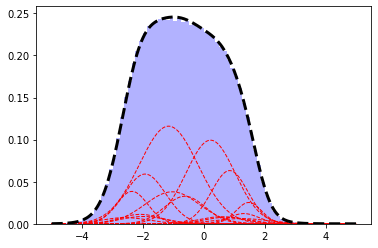

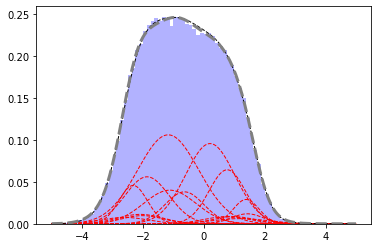

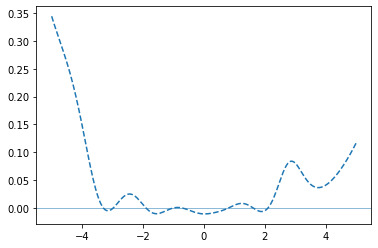

In [26]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

import matplotlib.pyplot as plt
from scipy import stats

params = density_model.likelihood_models[0].get_gauss_params([0])[0]
fracs  = params[:output_size_per_stage]
means  = params[output_size_per_stage:2*output_size_per_stage]
sigmas = params[2*output_size_per_stage:3*output_size_per_stage]

x = np.linspace(-5, 5, 201)
y1 = 0.
plt.hist(white_data_to_fit[0][:,0], weights=weights_to_fit[0], density=True, color="blue", alpha=0.3, bins=np.linspace(-5, 5, 81))
for i in range(output_size_per_stage) :
    yp = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
    plt.plot(x, yp, c="r", linewidth=1, linestyle="--")
    y1 = y1 + yp
plt.plot(x, y1, c="k", linewidth=3, linestyle="--")
plt.show()

params = density_model.likelihood_models[0].get_gauss_params([0.4])[0]
fracs  = params[:output_size_per_stage]
means  = params[output_size_per_stage:2*output_size_per_stage]
sigmas = params[2*output_size_per_stage:3*output_size_per_stage]

y2 = 0.
plt.hist(white_data_to_fit[0.4][:,0], weights=weights_to_fit[0.4], density=True, color="blue", alpha=0.3, bins=np.linspace(-5, 5, 81))
for i in range(output_size_per_stage) :
    yp = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
    plt.plot(x, yp, c="r", linewidth=1, linestyle="--")
    y2 = y2 + yp
plt.plot(x, y1, c="k", linewidth=1, linestyle="--")
plt.plot(x, y2, c="grey", linewidth=3, linestyle="--")
plt.show()

plt.plot(x, (y2-y1)/y1, "--")
plt.axhline(0, linewidth=0.5)
plt.show()


Filter efficiency is 100.000%


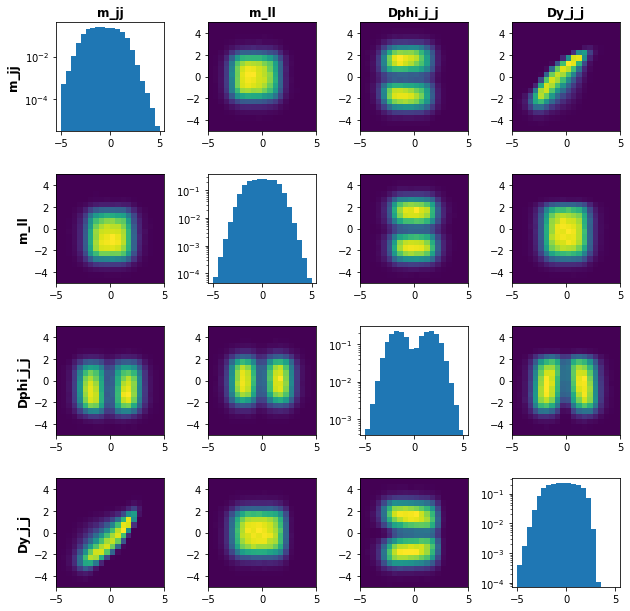

Filter efficiency is 100.000%


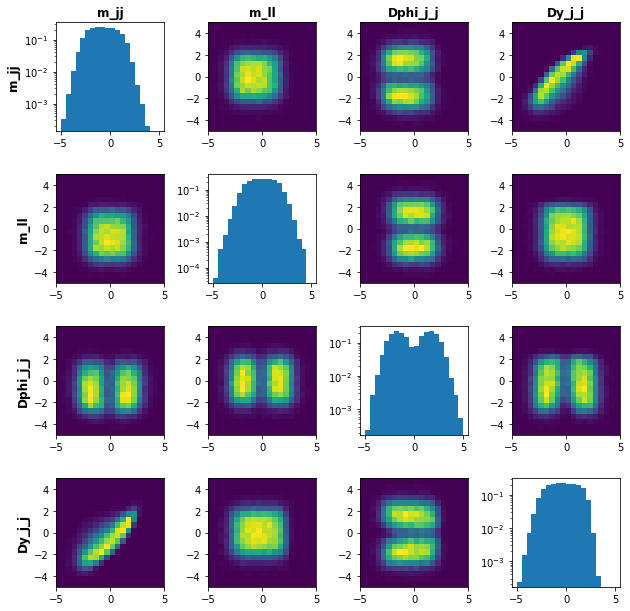

'plot_data(observable_data[0], weights_to_fit        [0], keys=data.keys, bins=10)\nplot_data(fake_datapoints_SM, fake_datapoint_weights[0], keys=data.keys, bins=10)\n\nplot_data(observable_data[0.2], weights_to_fit        [0.2], keys=data.keys, bins=10)\nplot_data(fake_datapoints_SM  , fake_datapoint_weights[0.2], keys=data.keys, bins=10)'

In [42]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit[0]    , weights_to_fit        [0]  , keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints_SM, fake_datapoint_weights[0]  , keys=data.keys, bins=20, lims=False)

'''plot_data(white_data_to_fit[0.4]  , weights_to_fit        [0.4], keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints_SM, fake_datapoint_weights[0.4], keys=data.keys, bins=20, lims=False)'''

'''plot_data(observable_data[0], weights_to_fit        [0], keys=data.keys, bins=10)
plot_data(fake_datapoints_SM, fake_datapoint_weights[0], keys=data.keys, bins=10)

plot_data(observable_data[0.2], weights_to_fit        [0.2], keys=data.keys, bins=10)
plot_data(fake_datapoints_SM  , fake_datapoint_weights[0.2], keys=data.keys, bins=10)'''

In [28]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"  , 1000, 5000])
cuts.append(["Dy_j_j", 2   , 8.8 ])

#plot_data(observable_data[0.2], weight_data[0.2], cuts=cuts, keys=data.keys, bins=10)
#plot_data(fake_datapoints[0.2], cuts=cuts, keys=data.keys, bins=10)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value enco

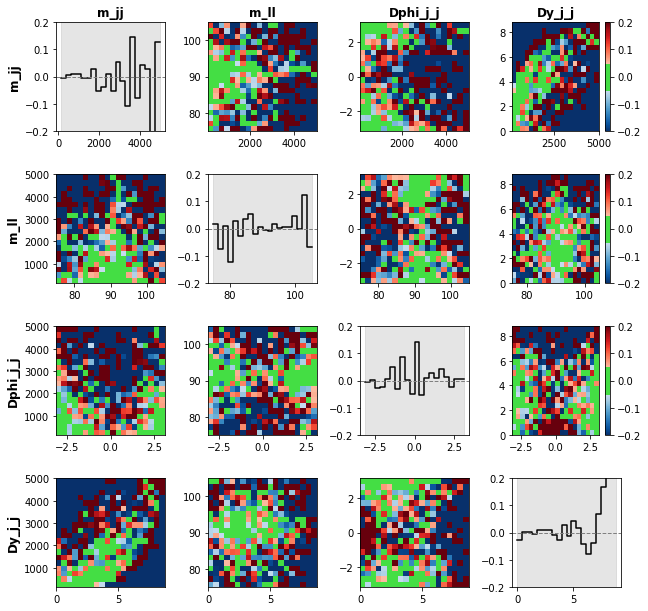

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value enco

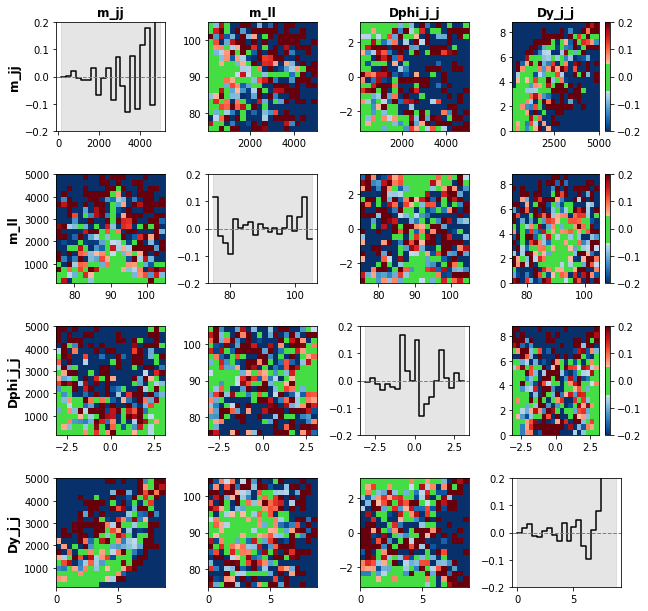

In [29]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(observable_data[0]  , fake_datapoints_SM, weights_to_fit[0]  , fake_datapoint_weights[0]  , keys=data.keys, bins=20)
plot_ratio(observable_data[0.4], fake_datapoints_SM, weights_to_fit[0.4], fake_datapoint_weights[0.4], keys=data.keys, bins=20)

#plot_ratio(observable_data[0.4], observable_data[0], weights_to_fit[0.4]        , weights_to_fit[0]        , keys=data.keys, bins=20)
#plot_ratio(fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)

#plot_pull (observable_data[0], fake_datapoints_SM, weights_to_fit[0], fake_datapoint_weights[0], keys=data.keys, bins=20)
#plot_pull (observable_data[0.2], fake_datapoints_SM, weights_to_fit[0.2], fake_datapoint_weights[0.2], keys=data.keys, bins=20)


In [30]:
#  Plot ratio between original and generated data (VBF fiducial)

#plot_ratio(observable_data[0], fake_datapoints[0], weight_data[0], None, keys=data.keys, bins=10, cuts=cuts)
#plot_pull(observable_data[0], fake_datapoints[0], weight_data[0], None, keys=data.keys, bins=10, cuts=cuts)

#  Plot pull between original and generated data (VBF fiducial)

#plot_ratio(observable_data[0.2], fake_datapoints[0.2], weight_data[0.2], None, keys=data.keys, bins=10, cuts=cuts)
#plot_pull(observable_data[0.2], fake_datapoints[0.2], weight_data[0.2], None, keys=data.keys, bins=10, cuts=cuts)


In [31]:
from matplotlib import pyplot as plt
from backends.plot import get_ratio_1D

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable (observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    print(f"Numerator filter efficiency is {100.*np.sum(filtered_weights_num)/np.sum(weights_num):.3f}%")
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    print(f"Denominator filter efficiency is {100.*np.sum(filtered_weights_den)/np.sum(weights_den):.3f}%")
    
    obs_idx = keys.index(observable)
    
    if lims : 
        obs_lims = observable_limits[observable]
    else :
        obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(observable, weight="bold", fontsize=12)
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    
    #ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.2, color="grey")
    
    ax.axhline(0 , linestyle="-", c="grey", linewidth=2)
    ax.axhline(0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.set_ylim([-0.9, 0.9])
    
    if type(label) != type(None) :
        ax.legend(loc="upper right", frameon=False, fontsize=16)
    
    plt.show()

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


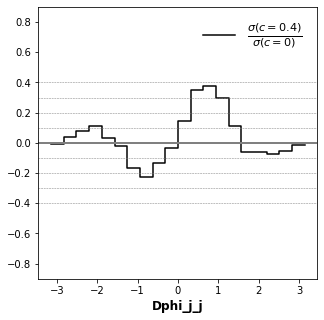

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


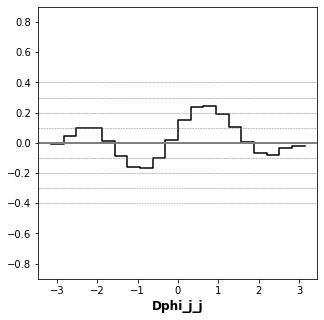

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


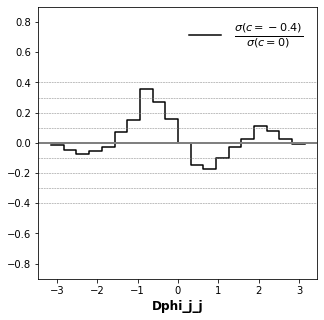

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


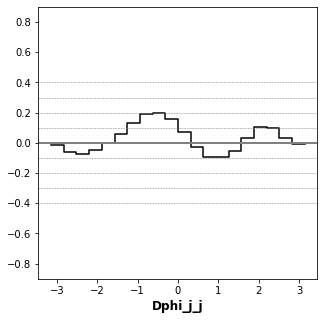

'plot_observable("Dy_j_j", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\x0crac{\\sigma(c=0.4)}{\\sigma(c=0)}$")\nplot_observable("Dy_j_j", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[-0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)\n\nplot_observable("m_jj", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\x0crac{\\sigma(c=0.4)}{\\sigma(c=0)}$")\nplot_observable("m_jj", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[-0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)\n'

In [32]:

plot_observable("Dphi_j_j", observable_data[0.4], observable_data[0], weights_to_fit[0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=0.4)}{\sigma(c=0)}$")
plot_observable("Dphi_j_j", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)

'''plot_observable("Dy_j_j", observable_data[0.4], observable_data[0], weights_to_fit[0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=0.4)}{\sigma(c=0)}$")
plot_observable("Dy_j_j", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)

plot_observable("m_jj", observable_data[0.4], observable_data[0], weights_to_fit[0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=0.4)}{\sigma(c=0)}$")
plot_observable("m_jj", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)
'''


#plot_observable("Dphi_j_j", fake_datapoints[0.4], fake_datapoints[0], None                       , None                     , keys=data.keys, bins=20)

plot_observable("Dphi_j_j", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=-0.4)}{\sigma(c=0)}$")
plot_observable("Dphi_j_j", fake_datapoints_SM   , fake_datapoints_SM, fake_datapoint_weights[-0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)

'''plot_observable("Dy_j_j", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=0.4)}{\sigma(c=0)}$")
plot_observable("Dy_j_j", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[-0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)

plot_observable("m_jj", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, label=r"$\frac{\sigma(c=0.4)}{\sigma(c=0)}$")
plot_observable("m_jj", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[-0.4], fake_datapoint_weights[0], keys=data.keys, bins=20)
'''



#plot_observable("Dphi_j_j", fake_datapoints[-0.4], fake_datapoints[0], None                        , None                     , keys=data.keys, bins=20)


Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.250%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.110%


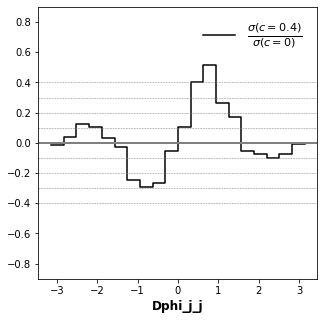

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.051%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.028%


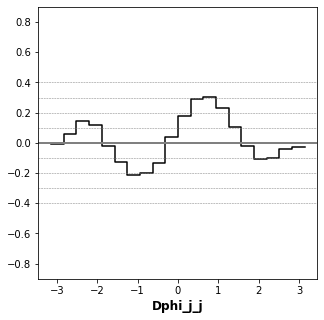

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.053%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.110%


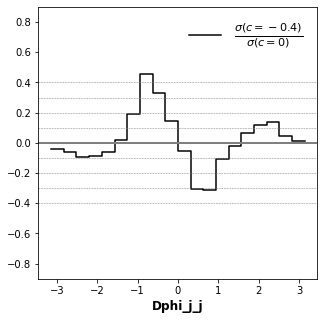

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 24.830%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.028%


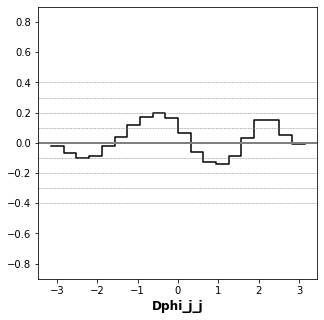

In [33]:

plot_observable("Dphi_j_j", observable_data[0.4], observable_data[0], weights_to_fit[0.4], weights_to_fit[0], keys=data.keys, cuts=cuts, bins=20, label=r"$\frac{\sigma(c=0.4)}{\sigma(c=0)}$")
plot_observable("Dphi_j_j", fake_datapoints_SM  , fake_datapoints_SM, fake_datapoint_weights[0.4], fake_datapoint_weights[0], keys=data.keys, cuts=cuts, bins=20)

plot_observable("Dphi_j_j", observable_data[-0.4], observable_data[0], weights_to_fit[-0.4], weights_to_fit[0], keys=data.keys, bins=20, cuts=cuts, label=r"$\frac{\sigma(c=-0.4)}{\sigma(c=0)}$")
plot_observable("Dphi_j_j", fake_datapoints_SM   , fake_datapoints_SM, fake_datapoint_weights[-0.4], fake_datapoint_weights[0], keys=data.keys, cuts=cuts, bins=20)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


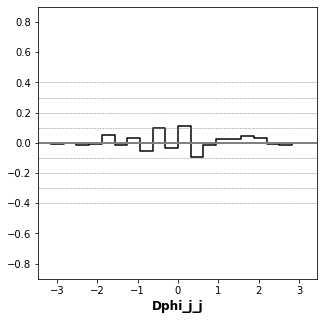

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


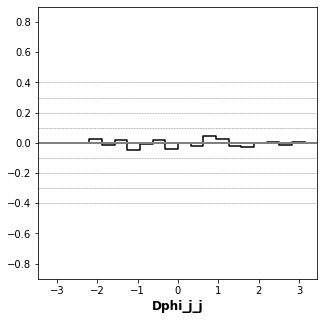

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


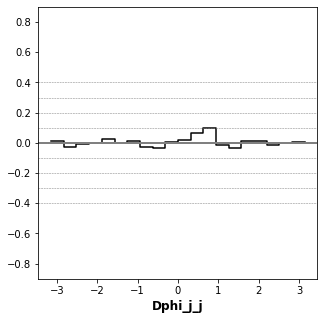

In [34]:

plot_observable("Dphi_j_j", fake_datapoints[0.2], observable_data[0.2], None, weight_data[0.2], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[0], observable_data[0], None, weight_data[0], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[-0.2], observable_data[-0.2], None, weight_data[-0.2], keys=data.keys, bins=20)


In [35]:
#  Plot the datapoints provided
#
def get_eff (data, weights=None, keys=[], cuts=[]) :
    if type(weights) == type(None) :
        weights = np.ones(shape=(data.shape[0],))
    filtered_data, filtered_weights = data, weights
    for cut in cuts :
        filtered_data, filtered_weights = filter_data (filtered_data, filtered_weights, keys, cut[0], cut[1], cut[2])
    return 100.*np.sum(filtered_weights)/np.sum(weights)


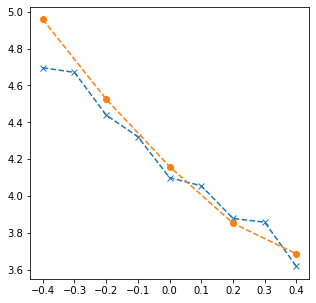

In [38]:
x1, x2, y1, y2 = [], [], [], []

for cWtil in sorted(cWtil_eval_vals) :
    e1 = get_eff(fake_datapoints[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x1.append(cWtil)
    y1.append(e1)
    
for cWtil in sorted(cWtil_vals) :
    e2 = get_eff(observable_data[cWtil], weights_to_fit[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x2.append(cWtil)
    y2.append(e2)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, y1, "x--")
ax.plot(x2, y2, "o--")
plt.show()

In [43]:
#   Plot
#   -  True interference part [small fluctuations]
#   -  Data   (c)  /  Data   (SM)
#   -  Sample (c)  /  Sample (SM)
#   -  Sample (SM) [reweighted]

In [128]:

#  Bin data in 1 dimension
#
def bin_data_1D (data, bins, weights=None, as_lines=False, normed=True) :
    if type(bins   ) == int        : bins    = np.linspace(np.min(data), np.max(data), bins+1)
    if type(data   ) != np.ndarray : data    = np.array(data)
    if type(weights) == type(None) : weights = np.ones(shape=data.shape)
    if normed : weights = weights / np.sum(weights)
    assert len(data) == len(weights)
    z , _ = np.histogram(data, bins=bins, weights=weights, density=False)
    ez, _ = np.histogram(data, bins=bins, weights=weights*weights, density=False)
    ez    = np.sqrt(ez)
    if not as_lines :
        return 0.5 * ( bins[:-1] + bins[0:] ), z, ez
    X, Z, EZ = [], [], []
    if as_lines :
        for zp in z :
            Z .append(zp)
            Z .append(zp)
        for ezp in ez :
            EZ.append(ezp)
            EZ.append(ezp)
        for i in range(len(bins)-1) :
            X .append(bins[i])
            X .append(bins[i+1])
    return np.array(X), np.array(Z), np.array(EZ)


#  Get 1D ratio between two histograms
#
def get_ratio_1D (data1, data2, bins, weights1=None, weights2=None, as_lines=False, normed=True) :
    X, Z1, EZ1 = bin_data_1D(data1, bins, weights1, as_lines=as_lines, normed=normed)
    X, Z2, EZ2 = bin_data_1D(data2, bins, weights2, as_lines=as_lines, normed=normed)
    frac_EZ1  = EZ1 / Z1
    frac_EZ2  = EZ2 / Z2
    ratio     = Z2 / Z1
    ratio_err = ratio * np.sqrt(frac_EZ1*frac_EZ1 + frac_EZ2*frac_EZ2)
    return X, ratio, ratio_err

In [136]:

#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    if ebar :ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.3, color="grey")
    ax.set_xlim([bins[0], bins[-1]])
    
    ax.axhline(0    , linestyle="-" , c="grey", linewidth=2  )
    for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
        ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
        

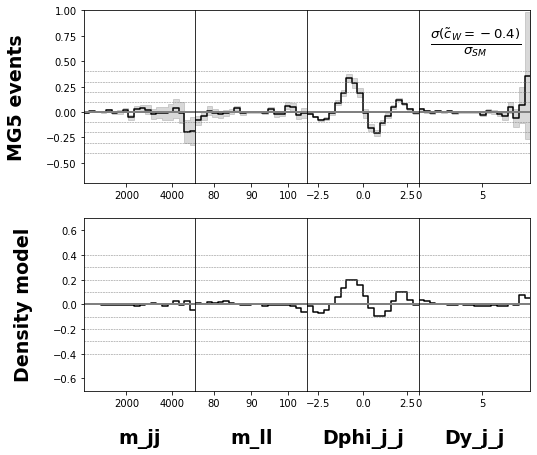

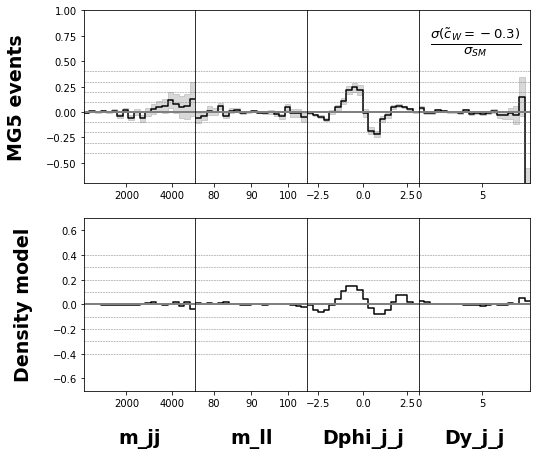

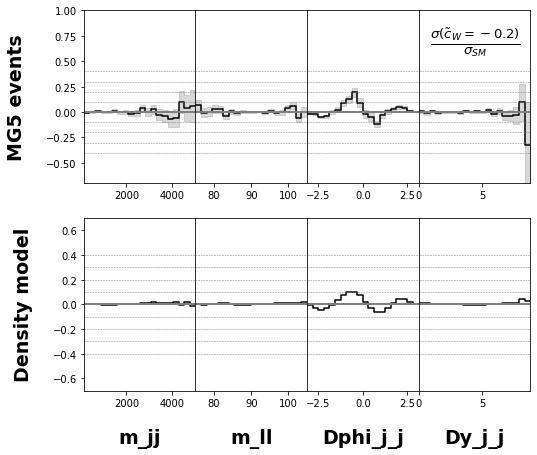

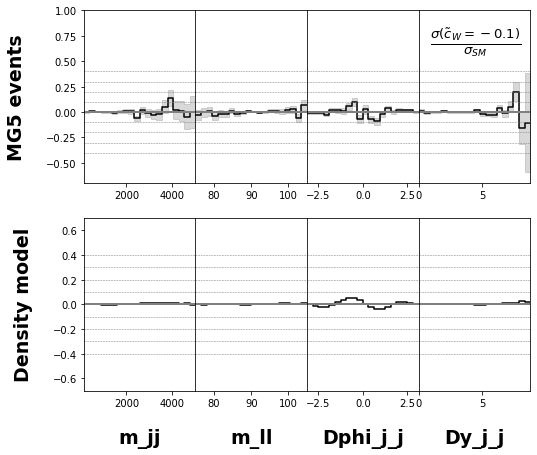

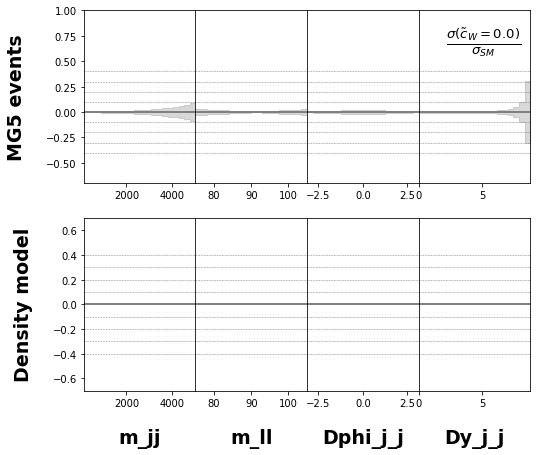

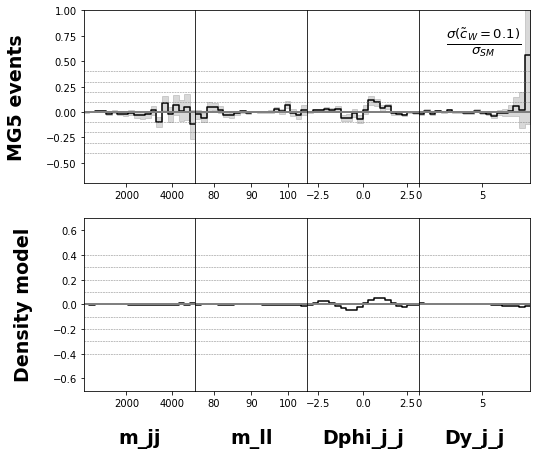

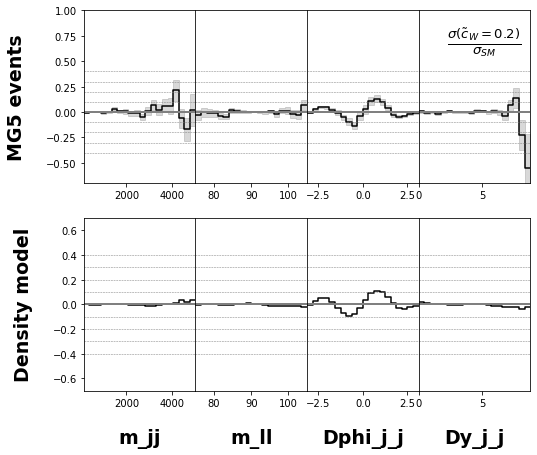

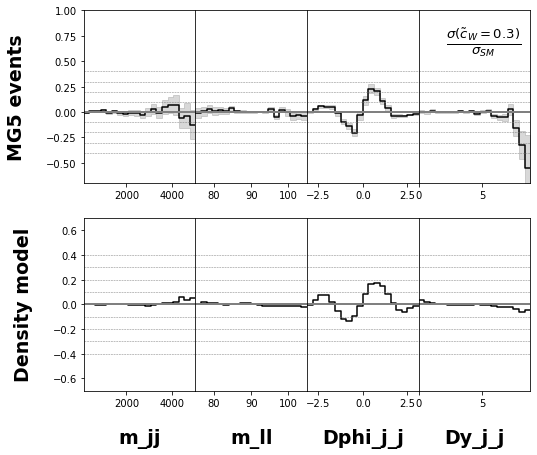

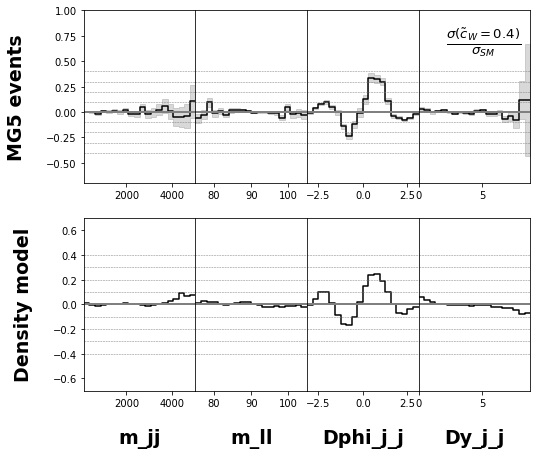

In [137]:

for fig_idx, cWtil in enumerate(sorted(cWtil_eval_vals)) :
    fig = plt.figure(figsize=(2*num_observables, 7))
    for idx, obs in enumerate(observables_order) :
        ax1 = fig.add_subplot(2, num_observables, 1+idx)
        data = data_tables [cWtil]
        observables, weights = data.get_observables_and_weights()
        plot_observable_on_axis (ax1, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True)
        ax2 = fig.add_subplot(2, num_observables, num_observables+1+idx)
        plot_observable_on_axis (ax2, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[cWtil], fake_datapoint_weights[0], keys=data.keys, bins=20, normed=True)
        ax2.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
        if idx == 0 :
            ax1.set_ylabel("MG5 events"   , fontsize=19, labelpad=20, weight="bold")
            ax2.set_ylabel("Density model", fontsize=19, labelpad=20, weight="bold")
        else :
            ax1.set_yticks([])
            ax2.set_yticks([])
        if idx == num_observables-1 :
            ax1.text(0.92, 0.92, r"$\frac{\sigma({\tilde c}_W="+f"{cWtil:.1f}"+r")}{\sigma_{SM}}$", fontsize=19, transform=ax1.transAxes, ha="right", va="top")
        ax1.set_ylim([-0.7, 1.])
        ax2.set_ylim([-0.7, 0.7])
    plt.subplots_adjust(wspace=0)
    plt.savefig(f"figures/EWK_cWtil_dependence_{fig_idx}.png", bbox_inches="tight")
    plt.show()
